# Задание лабораторной работы

## Блок 1. Загрузить и предобработать датасет

* Нормализовать данные для их приведения к диапазону [0, 1].
* Разделить данные на обучающую и тестовую выборки.
* Визуализировать данные и изучить их структуру.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.manifold import TSNE

# 1. Подготовка данных (взяли данные MNIST)

# # Аугментация для обучающих данных
# train_transform = transforms.Compose([
#     transforms.RandomRotation(20),  # Поворот на 20 градусов
#     transforms.RandomResizedCrop(28, scale=(0.95, 1.1)),  # Случайное масштабирование с сохранением размера
#     transforms.ToTensor(),  # Преобразование в тензор и нормализация в [0, 1]
# ])

# # Преобразования для тестовых данных (без аугментации)
# test_transform = transforms.Compose([
#     transforms.ToTensor(),  # Преобразование в тензор и нормализация в [0, 1]
# ])

# # разделить данные на train и test
# trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=train_transform)
# testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=test_transform)

transform = transforms.Compose([
    transforms.ToTensor(),  # Преобразование в тензор и нормализация в [0, 1]
])

# разделить данные на train и test
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

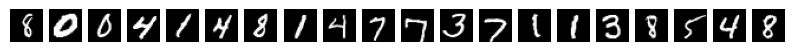

In [3]:
# визуализация данных
def visualize_data(loader, num_images=10):
    dataiter = iter(loader)
    images, labels = next(dataiter)

    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.axis('off')
    plt.show()

visualize_data(trainloader, 20)

## Блок 3. Реализация автокодировщика (AE):

* Создать классический автокодировщик для MNIST.
* Провести обучение и визуализировать результаты реконструкции.


In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

def visualize_ae_reconstruction(loader, model, num_images=10):
    dataiter = iter(loader)
    images, _ = next(dataiter)
    images = images.view(images.size(0), -1)
    images_tensor = images.to(device)

    # Реконструкция с помощью AE
    model.eval()
    with torch.no_grad():
        reconstructed = model(images_tensor).detach().cpu().numpy()

    # Визуализация
    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        # Оригинальные изображения
        plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i].reshape(28, 28).numpy(), cmap='gray')
        plt.axis('off')

        # Восстановленные изображения
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

    return images.numpy(), reconstructed


def visualize_latent_space_ae(loader, model, num_images=1000, num_batches=5):
    """
    Визуализация латентного пространства AE с использованием нескольких батчей.
    """
    model.eval()
    latent_list = []
    labels_list = []
    
    # Проходим по нескольким батчам
    for i, (images, labels) in enumerate(loader):
        if i >= num_batches:
            break
        
        images = images.view(images.size(0), -1).to(device)  # Преобразуем в тензор и перемещаем на устройство
        
        # Получаем латентное пространство с помощью энкодера
        with torch.no_grad():
            latent = model.encoder(images).detach().cpu().numpy()  # Латентное пространство
        
        latent_list.append(latent)
        labels_list.append(labels)
    
    # Объединяем данные из всех батчей
    latent = np.concatenate(latent_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)
    
    # Если размерность латентного пространства больше 2, используем t-SNE
    if latent.shape[1] > 2:
        tsne = TSNE(n_components=2, random_state=42)
        latent_2d = tsne.fit_transform(latent[:num_images])  # Уменьшаем размерность
    else:
        latent_2d = latent[:num_images]
    
    # Визуализация
    plt.figure(figsize=(8, 6))
    plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels[:num_images], cmap='tab10', s=5)
    plt.colorbar()
    plt.title("AE Latent Space")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()


# Инициализация модели и оптимизатора
model_ae = Autoencoder().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model_ae.parameters(), lr=0.001)

# Обучение модели
for epoch in range(10):
    progress_bar = tqdm(trainloader, desc=f'Epoch {epoch+1}', leave=False)
    for data in progress_bar:
        img, _ = data
        img = img.to(device)
        img = img.view(img.size(0), -1)
        output = model_ae(img)
        loss = criterion(output, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        progress_bar.set_postfix(loss=loss.item())

    # tqdm.write(f'Epoch {epoch+1}, Loss: {loss.item():.3f}')

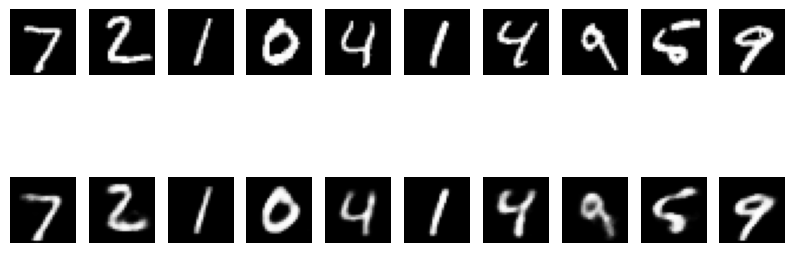

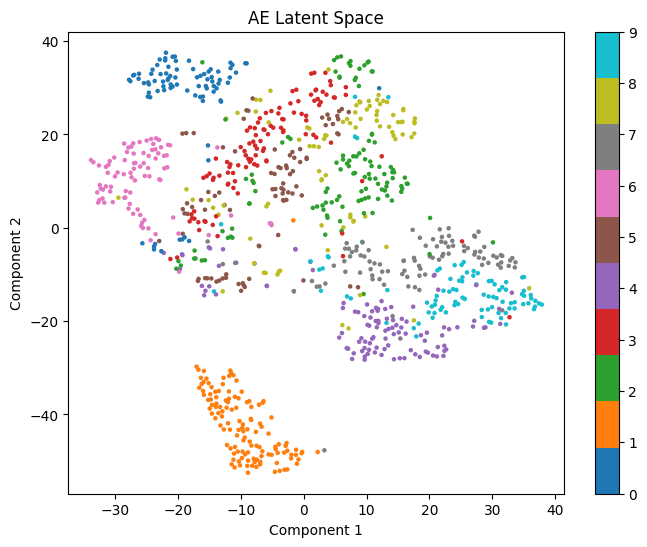

In [7]:
original_ae, recon_ae = visualize_ae_reconstruction(testloader, model_ae)
visualize_latent_space_ae(testloader, model_ae, num_batches=1000)

## Блок 4. Реализация вариационного автокодировщика (VAE):
* Реализовать архитектуру VAE.
* Провести обучение и визуализировать латентное пространство.


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # энкодер переводит изображение MNIST из размерности 28х28 в 64 для сохранения только важных признаков
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        # задаем среднее и дисперсию для моделирования латентного пространство как гауссового распределение
        # среднее значение
        self.fc_mu = nn.Linear(64, 32)
        # логарифм дисперсии
        self.fc_logvar = nn.Linear(64, 32)

        # декодер
        self.decoder = nn.Sequential(
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 28*28),
            # для получения диапазона [0, 1]
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        """
        Моделируем латентное пространство как гауссово распределение
        """
        # стандартное отклонение
        std = torch.exp(0.5 * logvar)
        # шум из нормального распределения
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        # кодирование в латентное пространство
        mu, logvar = self.encode(x.view(-1, 28*28))
        # репараметризация
        z = self.reparameterize(mu, logvar)
        # декодирование и возврат параметров
        return self.decode(z), mu, logvar

# функция потерь для VAE
def loss_function(recon_x, x, mu, logvar, beta=1.0):
    # Реконструкционная ошибка
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    # KL-дивергенция
    # beta - гиперпараметр, который контролирует вклад KLD в общую ошибку
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD , BCE, KLD

# обучение модели
def train(model, epoch, beta=1.0):
    model.train()
    train_loss = 0

    BCE_per_epoch = []
    KLD_per_epoch = []

    # Обертываем trainloader в tqdm для отображения прогресса
    progress_bar = tqdm(trainloader, desc=f'Epoch {epoch}', leave=False)
    for data, _ in progress_bar:

        data = data.to(device)
        optimizer.zero_grad()
        # прямой проход
        recon_batch, mu, logvar = model(data)
        # считаем loss
        loss, BCE, KLD = loss_function(recon_batch, data, mu, logvar, beta)
        BCE_per_epoch.append(BCE.item())
        KLD_per_epoch.append(KLD.item())

        # обратное распространение
        loss.backward()
        train_loss += loss.item()
        # обновление весов
        optimizer.step()

# Визуализация латентного пространства
def visualize_latent_space(loader, model):
    model.eval()
    all_mu = []  # Список для хранения всех mu
    all_labels = []  # Список для хранения всех меток

    with torch.no_grad():
        for data in loader:
            img, labels = data
            img = img.view(img.size(0), -1).to(device)  # Преобразуем и перемещаем на устройство
            mu, _ = model.encode(img)  # Получаем mu из энкодера
            all_mu.append(mu.cpu().numpy())  # Сохраняем mu
            all_labels.append(labels.cpu().numpy())  # Сохраняем метки

    # Объединяем данные из всех батчей
    all_mu = np.concatenate(all_mu, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # Визуализация
    plt.figure(figsize=(8, 6))
    plt.scatter(all_mu[:, 0], all_mu[:, 1], c=all_labels, cmap='tab10', s=5)
    plt.colorbar()
    plt.title("Латентное пространство VAE (2D)")
    plt.xlabel("Компонента 1")
    plt.ylabel("Компонента 2")
    plt.show()

def visualize_vae_reconstruction(loader, model, num_images=10):
    dataiter = iter(loader)
    images, _ = next(dataiter)
    images = images.view(images.size(0), -1)
    images_tensor = images.to(device)

    # Реконструкция с помощью VAE
    model.eval()
    with torch.no_grad():
        reconstructed, _, _ = model(images_tensor)
        reconstructed = reconstructed.detach().cpu().numpy()

    # Визуализация
    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        # Оригинальные изображения
        plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i].reshape(28, 28).numpy(), cmap='gray')
        plt.axis('off')

        # Восстановленные изображения
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

    return images.numpy(), reconstructed

# инициализация модели и оптимизатора
model_vae = VAE().to(device)
optimizer = optim.Adam(model_vae.parameters(), lr=1e-3)

# Обучение модели
epochs = 10
for epoch in range(1, epochs + 1):
    train(model_vae, epoch, 0.6)

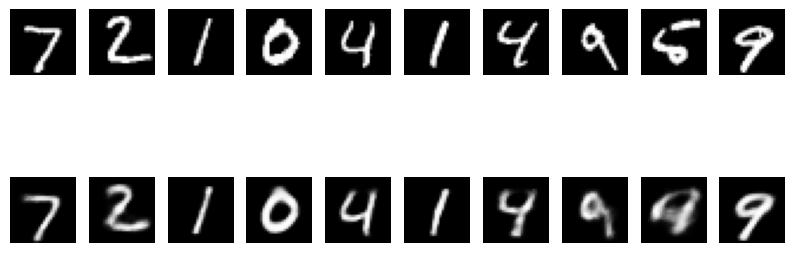

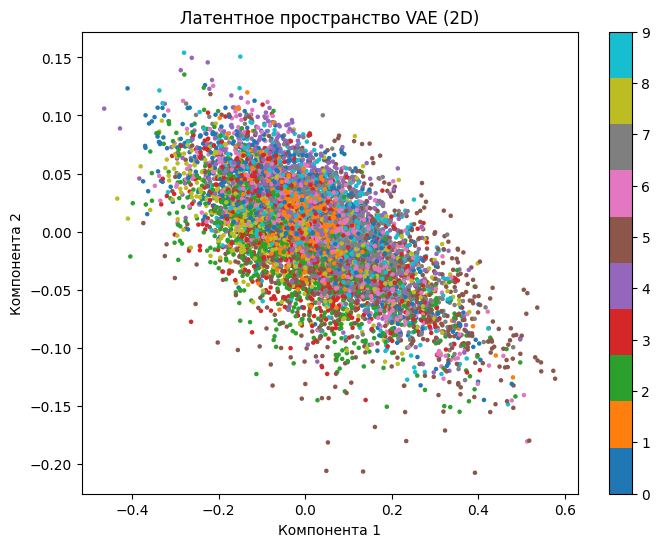

In [13]:
# визуализация реконструкции после обучения
original_vae, recon_vae = visualize_vae_reconstruction(testloader, model_vae)
visualize_latent_space(testloader, model_vae)

## Блок 5. Сравнение PCA, AE и VAE:
* Реализовать PCA для уменьшения размерности данных.
* Сравнить результаты реконструкции данных между PCA, AE и VAE.
* Оценить латентное пространство и вычислить метрики качества.


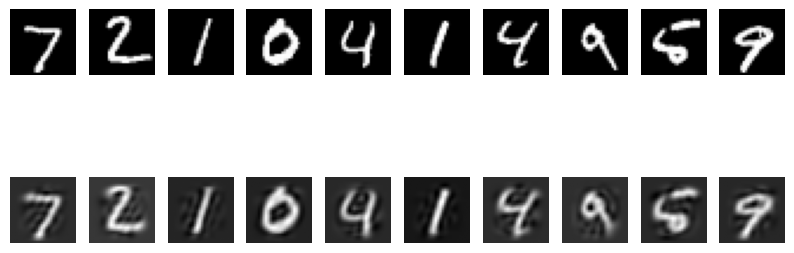

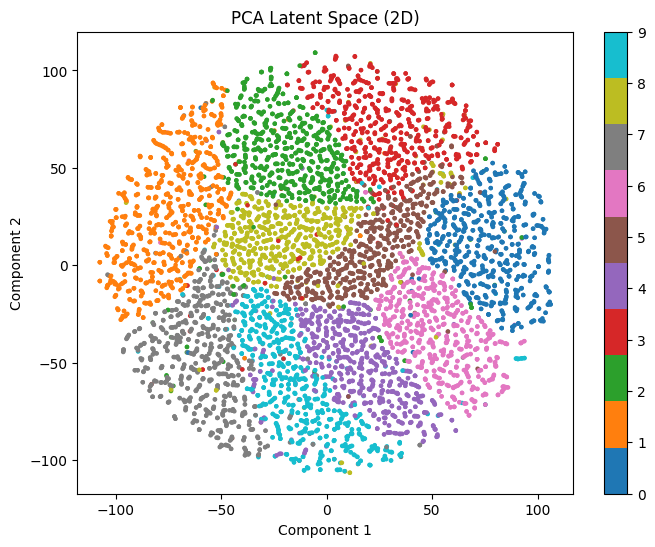

In [22]:
from sklearn.decomposition import PCA

def visualize_pca_reconstruction(original_data, model, num_images=10):
    # Реконструкция с помощью PCA
    latent = pca.transform(original_data)
    reconstructed = model.inverse_transform(latent)

    # Визуализация
    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        # Оригинальные изображения
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original_data[i].reshape(28, 28), cmap='gray')
        plt.axis('off')

        # Восстановленные изображения
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

    return original_data, reconstructed


def visualize_latent_space_pca(model, data, labels, num_images=10):
    """
    Визуализация латентного пространства PCA.
    """
    # Получаем латентное пространство с помощью PCA
    latent = model.transform(data)

    # Если размерность латентного пространства больше 2, используем t-SNE
    if latent.shape[1] > 2:
        tsne = TSNE(n_components=2, random_state=42, perplexity=2)
        latent_2d = tsne.fit_transform(latent[:num_images])  # Уменьшаем размерность
    else:
        latent_2d = latent[:num_images]  # Используем как есть, если размерность 2

    # Визуализация
    plt.figure(figsize=(8, 6))
    plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels[:num_images], cmap='tab10', s=5)
    plt.colorbar()
    plt.title("PCA Latent Space (2D)")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()


# Преобразование данных в одномерный массив
x_train_flat = trainset.data.numpy().reshape(len(trainset), -1)
x_test_flat = testset.data.numpy().reshape(len(testset), -1)

# Реализация PCA
pca = PCA(n_components=64)
x_train_pca = pca.fit_transform(x_train_flat)  # Обучение PCA на тренировочных данных
x_test_pca = pca.transform(x_test_flat)  # Применение PCA к тестовым данным

# Обратное преобразование для визуализации реконструкции
x_train_reconstructed = pca.inverse_transform(x_train_pca)
x_test_reconstructed = pca.inverse_transform(x_test_pca)

# Визуализация реконструкции PCA
original_pca, recon_pca = visualize_pca_reconstruction(x_test_flat, pca)
visualize_latent_space_pca(pca, x_test_flat, testset.targets.numpy(), 60000)

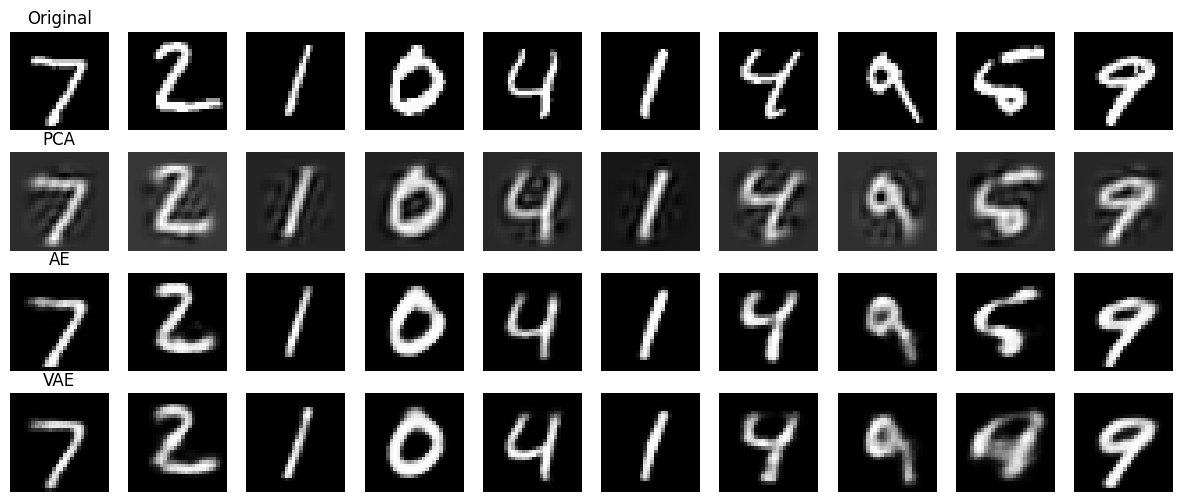

In [23]:
def compare_reconstructions(original, pca_recon, ae_recon, vae_recon, num_images=10):
    plt.figure(figsize=(15, 6))
    for i in range(num_images):

        plt.subplot(4, num_images, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap='gray')
        if i == 0:
          plt.title("Original")
        plt.axis('off')

        plt.subplot(4, num_images, num_images + i + 1)
        plt.imshow(pca_recon[i].reshape(28, 28), cmap='gray')
        if i == 0:
          plt.title("PCA")
        plt.axis('off')

        plt.subplot(4, num_images, 2 * num_images + i + 1)
        plt.imshow(ae_recon[i].reshape(28, 28), cmap='gray')
        if i == 0:
          plt.title("AE")
        plt.axis('off')

        plt.subplot(4, num_images, 3 * num_images + i + 1)
        plt.imshow(vae_recon[i].reshape(28, 28), cmap='gray')
        if i == 0:
          plt.title("VAE")
        plt.axis('off')
    plt.show()

# Визуализация сравнения реконструкций
compare_reconstructions(original_pca, recon_pca, recon_ae, recon_vae)

In [154]:
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim

# Функция для вычисления MSE
def calculate_mse(original, reconstructed):
    return mean_squared_error(original, reconstructed)

# Вычисление метрик для PCA
for name, eval in zip(["AE", "VAE", 'PCA'], [recon_pca, recon_ae, recon_vae]):

  mse_val = calculate_mse(original_pca[:10], eval[:10])

  print(f"MSE {name}: {mse_val:>6.2f}")

MSE AE: 541.7653
MSE VAE: 6363.2310
MSE PCA: 6363.5972


Видно, что методы можно проранжировать по признаку сильного сходства с оригинальными данными. Наиболее близкий это AE, потом VAE и PCA более сильно меняет исходные данные. Это видно как с картинок, так и при оценки метрик. Несмотря на хороший результат MSE для AE это не означает, что он просто не запомнил исходные данные.   

## Блок 6. Сравнение с CNN:

* Реализовать сверточную нейронную сеть (CNN) для классификации MNIST.
* Сравнить метрики точности и эффективности между CNN, AE и VAE.
* Изучить влияние архитектуры CNN на результаты.


In [8]:
# Определение модели CNN Autoencoder (CAE)
class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        # Энкодер
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Декодер
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2),
            nn.Sigmoid()  # Приводим значения к диапазону [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Функция для визуализации реконструкции
def visualize_cnn_reconstruction(loader, model, num_images=10):
    dataiter = iter(loader)
    images, _ = next(dataiter)
    images = images.to(device)

    # Реконструкция с помощью CNN
    model.eval()
    with torch.no_grad():
        reconstructed = model(images)
        reconstructed = reconstructed.detach().cpu().numpy()

    # Визуализация
    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        # Оригинальные изображения
        plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i].cpu().numpy().squeeze(), cmap='gray')
        plt.axis('off')

        # Восстановленные изображения
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(reconstructed[i].squeeze(), cmap='gray')
        plt.axis('off')
    plt.show()

# Функция для визуализации латентного пространства
def visualize_latent_space_cnn(loader, model, num_images=1000):
    model.eval()
    with torch.no_grad():
        for data in loader:
            img, labels = data
            img = img.to(device)
            # Получаем латентное представление
            latent = model.encoder(img)
            latent = latent.view(latent.size(0), -1)  # Преобразуем в 2D (batch_size, 64*7*7)

            # Уменьшаем размерность с помощью t-SNE
            if latent.shape[1] > 2:
                tsne = TSNE(n_components=2, random_state=42)
                latent_2d = tsne.fit_transform(latent.cpu().numpy()[:num_images])
            else:
                latent_2d = latent.cpu().numpy()[:num_images]

            # Визуализация
            plt.figure(figsize=(8, 6))
            plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels[:num_images], cmap='tab10', s=5)
            plt.colorbar()
            plt.title("Латентное пространство CNN (2D)")
            plt.xlabel("Component 1")
            plt.ylabel("Component 2")
            plt.show()
            break

# Функция для обучения модели
def train_cnn(model, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(trainloader):
        data = data.to(device)
        optimizer.zero_grad()
        # Прямой проход
        output = model(data)
        # Вычисление ошибки
        loss = criterion(output, data)
        # Обратное распространение
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {train_loss / len(trainloader):.4f}')

In [ ]:
model_cnn = CAE().to(device)
# Функция потерь MSE, т.к. BCE не отражает "качество" модели
# criterion = nn.BCELoss()
criterion = nn.MSELoss()
# Оптимизатор
optimizer = optim.Adam(model_cnn.parameters(), lr=1e-3)

# Обучение модели
for epoch in range(10):
    train_cnn(model_cnn, epoch)

# Визуализация предсказаний
visualize_cnn_reconstruction(testloader, model_cnn)

# Визуализация латентного пространства
visualize_latent_space_cnn(testloader, model_cnn)

## Блок 7. Генерация данных:
* Сгенерировать изображения из случайных точек латентного пространства VAE.
* Провести интерполяцию между двумя точками латентного пространства.
* Исследовать влияние размерности латентного пространства на качество генерации.
* Добавить шум в латентное пространство и оценить влияние на генерацию.


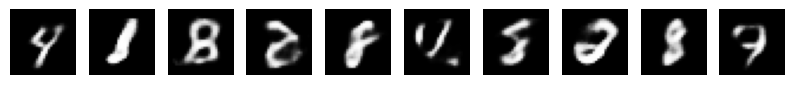

In [5]:
# Генерация случайных точек в латентном пространстве VAE
latent_samples = torch.randn(10, 20)
generated_images = model_vae.decode(latent_samples.to(device)).view(-1, 28, 28)

# Визуализация сгенерированных изображений
plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(generated_images[i].detach().cpu().numpy(), cmap='gray')
    plt.axis('off')
plt.show()

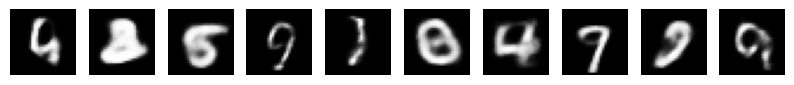

In [39]:
import torch
import matplotlib.pyplot as plt

def generate_images(model, num_images=10, latent_dim=32):
    """
    Генерация изображений из случайных точек латентного пространства.
    """
    model.eval()
    with torch.no_grad():
        # Создаем случайные точки в латентном пространстве
        z = torch.randn(num_images, latent_dim).to(device)
        # Декодируем в изображения
        generated_images = model.decode(z).cpu()
    
    # Визуализация
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(generated_images[i].view(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

# Пример использования
generate_images(model_vae, num_images=10)

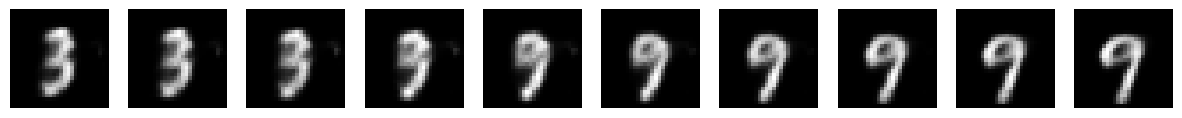

In [43]:
def interpolate(model, z1, z2, num_steps=10):
    """
    Интерполяция между двумя точками латентного пространства.
    """
    model.eval()
    with torch.no_grad():
        # Линейная интерполяция
        weights = np.linspace(0, 1, num_steps)
        interpolated_images = []
        for w in weights:
            z = w * z1 + (1 - w) * z2  # Интерполяция
            img = model.decode(z).cpu()
            interpolated_images.append(img)
    
    # Визуализация
    plt.figure(figsize=(15, 2))
    for i, img in enumerate(interpolated_images):
        plt.subplot(1, num_steps, i+1)
        plt.imshow(img.view(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

# Пример использования
z1 = torch.randn(1, 32).to(device)  # Первая точка
z2 = torch.randn(1, 32).to(device)  # Вторая точка
interpolate(model_vae, z1, z2, num_steps=10)


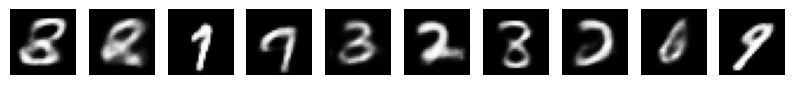

In [52]:
def add_noise_and_generate(model, z, noise_std=0.1):
    """
    Добавление шума в латентное пространство и генерация изображений.
    """
    model.eval()
    with torch.no_grad():
        # Добавляем шум
        noise = torch.randn_like(z) * noise_std
        z_noisy = z + noise
        # Декодируем
        generated_images = model.decode(z_noisy).cpu()
    
    # Визуализация
    plt.figure(figsize=(10, 2))
    for i in range(len(z)):
        plt.subplot(1, len(z), i+1)
        plt.imshow(generated_images[i].view(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

# Пример использования
z = torch.randn(10, 32).to(device)  # Точки в латентном пространстве
add_noise_and_generate(model_vae, z, noise_std=0.2)

## Блок 8. Сравнение VAE и GAN:
* Реализовать простую архитектуру GAN для генерации изображений.
* Сравнить качество изображений, сгенерированных VAE и GAN.
* Провести интерполяцию в латентном пространстве GAN.


In [32]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 28*28),
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.model(z).view(-1, 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        return self.model(img_flat)

# Инициализация GAN
latent_dim = 100
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

# Применяем инициализацию
generator.apply(weights_init)
discriminator.apply(weights_init)


optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

criterion = nn.BCELoss()

# Обучение GAN
for epoch in range(10):
    progress_bar = tqdm(trainloader, desc=f'Epoch {epoch+1}', leave=False)
    for i, (imgs, _) in enumerate(progress_bar):
        imgs = imgs.to(device)
        real_labels = torch.ones(imgs.size(0), 1).to(device)
        fake_labels = torch.zeros(imgs.size(0), 1).to(device)

        # Обучение дискриминатора
        optimizer_D.zero_grad()
        real_loss = criterion(discriminator(imgs), real_labels)
        z = torch.randn(imgs.size(0), latent_dim).to(device)
        fake_imgs = generator(z)
        fake_loss = criterion(discriminator(fake_imgs.detach()), fake_labels)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # Обучение генератора
        optimizer_G.zero_grad()
        z = torch.randn(imgs.size(0), latent_dim).to(device)
        fake_imgs = generator(z)
        g_loss = criterion(discriminator(fake_imgs), real_labels)
        g_loss.backward()
        optimizer_G.step()

        progress_bar.set_postfix(D_loss=d_loss.item(), G_loss=g_loss.item())

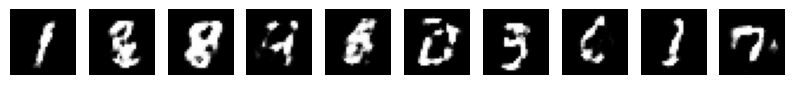

In [38]:
# Генерация изображений с помощью GAN
z = torch.randn(10, latent_dim).to(device)
generated_images = generator(z)

# Визуализация сгенерированных изображений
plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(generated_images[i].squeeze().detach().cpu().numpy(), cmap='gray')
    plt.axis('off')
plt.show()